In [58]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)

import ebaysdk
from ebaysdk.finding import Connection as Finding
from ebaysdk.trading import Connection as Trading
from ebaysdk.exception import ConnectionError

import pickle
from collections import Counter

In [32]:
with open('/Users/donalddressen/Desktop/auction_data/auctions_df_final.pkl', 'rb') as f:
    auc_df_final = pickle.load(f)

In [33]:
auc_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 34 columns):
auction start time           4000 non-null object
autopays                     4000 non-null object
best offer                   4000 non-null object
bid count                    4000 non-null int64
category ID                  4000 non-null object
category name                4000 non-null object
condition ID                 4000 non-null object
end price                    4000 non-null float64
item ID                      4000 non-null object
item url                     4000 non-null object
missing pic                  4000 non-null int64
number of payment methods    4000 non-null int64
pic url                      4000 non-null object
postal code                  4000 non-null int64
seller percent               4000 non-null float64
seller score                 4000 non-null int64
seller star                  4000 non-null object
selling state                4000 non-null obj

In [41]:
reduce_df = auc_df_final[auc_df_final['bid count'] > 0]

In [42]:
reduce_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2999 entries, 1 to 3999
Data columns (total 34 columns):
auction start time           2999 non-null object
autopays                     2999 non-null object
best offer                   2999 non-null object
bid count                    2999 non-null int64
category ID                  2999 non-null object
category name                2999 non-null object
condition ID                 2999 non-null object
end price                    2999 non-null float64
item ID                      2999 non-null object
item url                     2999 non-null object
missing pic                  2999 non-null int64
number of payment methods    2999 non-null int64
pic url                      2999 non-null object
postal code                  2999 non-null int64
seller percent               2999 non-null float64
seller score                 2999 non-null int64
seller star                  2999 non-null object
selling state                2999 non-null obj

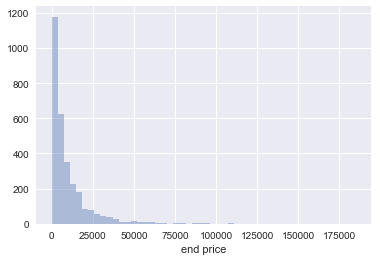

In [43]:
sns.distplot(reduce_df['end price'], kde=False)

In [44]:
reduce_df = reduce_df[reduce_df['missing pic'] < 1]

In [45]:
reduce_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2974 entries, 1 to 3999
Data columns (total 34 columns):
auction start time           2974 non-null object
autopays                     2974 non-null object
best offer                   2974 non-null object
bid count                    2974 non-null int64
category ID                  2974 non-null object
category name                2974 non-null object
condition ID                 2974 non-null object
end price                    2974 non-null float64
item ID                      2974 non-null object
item url                     2974 non-null object
missing pic                  2974 non-null int64
number of payment methods    2974 non-null int64
pic url                      2974 non-null object
postal code                  2974 non-null int64
seller percent               2974 non-null float64
seller score                 2974 non-null int64
seller star                  2974 non-null object
selling state                2974 non-null obj

In [47]:
reduce_df['reserve met']

1       false
2       false
4        true
6       false
7        true
8       false
10      false
11      false
18      false
19      false
20       true
21       true
22      false
29       true
31       true
32      false
33      false
34       true
37      false
39      false
40      false
41       true
42      false
44       true
46       true
47       true
48      false
49       true
50      false
52       true
        ...  
3970     true
3971     true
3972     true
3973     true
3974     true
3975     true
3976     true
3977     true
3978     true
3979     true
3980     true
3981     true
3982     true
3983     true
3984     true
3985     true
3986     true
3987     true
3988     true
3989     true
3990     true
3991     true
3992     true
3993     true
3994     true
3995       NA
3996       NA
3997       NA
3998       NA
3999       NA
Name: reserve met, Length: 2974, dtype: object

In [48]:
reduce_df = reduce_df[reduce_df['reserve met'] == 'true']

In [49]:
reduce_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1681 entries, 4 to 3994
Data columns (total 34 columns):
auction start time           1681 non-null object
autopays                     1681 non-null object
best offer                   1681 non-null object
bid count                    1681 non-null int64
category ID                  1681 non-null object
category name                1681 non-null object
condition ID                 1681 non-null object
end price                    1681 non-null float64
item ID                      1681 non-null object
item url                     1681 non-null object
missing pic                  1681 non-null int64
number of payment methods    1681 non-null int64
pic url                      1681 non-null object
postal code                  1681 non-null int64
seller percent               1681 non-null float64
seller score                 1681 non-null int64
seller star                  1681 non-null object
selling state                1681 non-null obj

In [50]:
model_df = pd.concat([ 
    reduce_df['category ID'], 
    reduce_df['condition ID'], 
    reduce_df['end price'], 
    reduce_df['item ID'], 
    reduce_df['number of payment methods'],
    reduce_df['seller percent'],
    reduce_df['seller score'],
    reduce_df['seller star'],
    reduce_df['top rated'],
    reduce_df['reserve'],
    reduce_df['start price'],
    reduce_df['photo number'],
    reduce_df['postal code'],
    reduce_df['year'],
    reduce_df['mileage']
], axis=1)

In [51]:
star_mapping = {"None": 0, 
                "Yellow": 1, 
                "Blue": 2, 
                "Turquoise": 3, 
                "Purple": 4,
                "Red": 5,
                "Green": 6,
                "YellowShooting": 7,
                "TurquoiseShooting": 8,
                "PurpleShooting": 9,
                "RedShooting": 10,
                "GreenShooting": 11,
                "SilverShooting": 12
               }

model_df['seller star'] = model_df['seller star'].map(star_mapping)
model_df['seller star'] = model_df['seller star'].fillna(0)

In [53]:
model_df['top rated'] = model_df['top rated'].astype(bool)

In [54]:
model_df['top rated'] = model_df['top rated'].astype(int)

In [55]:
model_df['reserve'] = model_df['reserve'].astype(bool)

In [56]:
model_df['reserve'] = model_df['reserve'].astype(int)

In [60]:
model_df['category ID'] = model_df['category ID'].astype(int)

In [64]:
model_df['condition ID'] = model_df['condition ID'].astype(int)

In [67]:
model_df['item ID'] = model_df['item ID'].astype(int)

In [68]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1681 entries, 4 to 3994
Data columns (total 15 columns):
category ID                  1681 non-null int64
condition ID                 1681 non-null int64
end price                    1681 non-null float64
item ID                      1681 non-null int64
number of payment methods    1681 non-null int64
seller percent               1681 non-null float64
seller score                 1681 non-null int64
seller star                  1681 non-null int64
top rated                    1681 non-null int64
reserve                      1681 non-null int64
start price                  1681 non-null float64
photo number                 1681 non-null int64
postal code                  1681 non-null int64
year                         1681 non-null int64
mileage                      1681 non-null int64
dtypes: float64(3), int64(12)
memory usage: 210.1 KB


In [66]:
Counter(model_df['condition ID'])

Counter({1000: 6, 2500: 25, 3000: 1650})

In [69]:
with open('/Users/donalddressen/Desktop/auction_data/model_df.pkl', 'wb') as f:
    pickle.dump(model_df, f)